[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


NLTK setup complete.
Data loaded successfully from twitter_training.csv
Data preparation complete.

Value counts for each sentiment:
sentiment
Negative    22358
Positive    20655
Neutral     18108
Name: count, dtype: int64

Preprocessing text data... This may take a moment.
Training the model...
Model training complete.

Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

    Positive       0.89      0.90      0.89      5164
    Negative       0.82      0.96      0.88      5590
     Neutral       0.96      0.75      0.85      4527

    accuracy                           0.88     15281
   macro avg       0.89      0.87      0.87     15281
weighted avg       0.89      0.88      0.87     15281



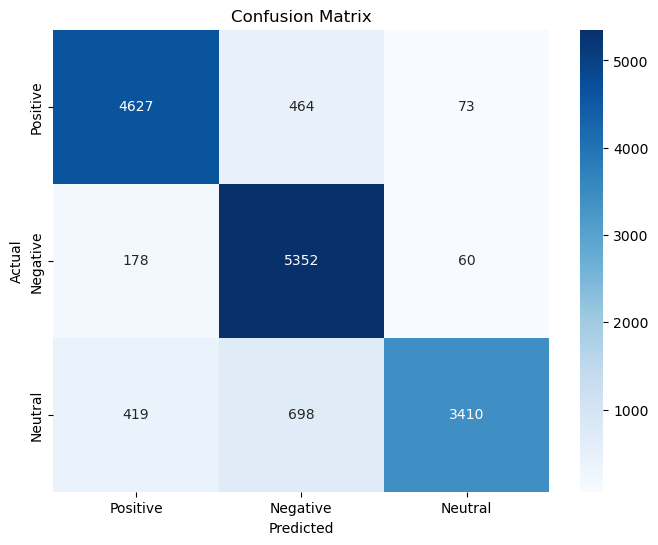


--- Interactive Prediction ---
Tweet: "This new game is absolutely amazing! #Gaming"
Predicted Sentiment: Positive (Confidence: 0.56)
------------------------------
Tweet: "I'm so frustrated with the latest update, it's full of bugs."
Predicted Sentiment: Negative (Confidence: 0.79)
------------------------------
Tweet: "Just finished watching the new episode. It was okay."
Predicted Sentiment: Positive (Confidence: 0.51)
------------------------------


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def setup_nltk():
    """
    Downloads necessary NLTK data if not already present.
    """
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet')
    try:
        nltk.data.find('corpora/omw-1.4')
    except LookupError:
        nltk.download('omw-1.4')
    print("NLTK setup complete.")

def load_and_prepare_data(file_path='twitter_training.csv'):
    """
    Loads data from the twitter_training.csv file and prepares it.
    """
    try:
        # This file has no header. We'll name the columns upon loading.
        col_names = ['ID', 'Topic', 'Sentiment', 'Review']
        df = pd.read_csv("C:\\Users\\HP\\Downloads\\twitter_training.csv", header=None, names=col_names, encoding='utf-8')
        print(f"Data loaded successfully from {file_path}")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please ensure it's in the same directory.")
        return None

    # Drop rows where essential data is missing
    df.dropna(subset=['Review', 'Sentiment'], inplace=True)

    # Filter for the three valid sentiment categories, ignoring 'Irrelevant'
    df = df[df['Sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
    
    # The sentiment labels are already in the correct Title Case format.
    
    # Create a new, clean DataFrame with only the columns we need
    clean_df = df[['Review', 'Sentiment']].copy()
    # Rename columns for consistency with the rest of the script
    clean_df.rename(columns={'Review': 'review', 'Sentiment': 'sentiment'}, inplace=True)
    
    print("Data preparation complete.")
    print("\nValue counts for each sentiment:")
    print(clean_df['sentiment'].value_counts())
    
    return clean_df


def preprocess_text(text, lemmatizer, stop_words):
    """
    Cleans and preprocesses a single text string from a tweet.
    """
    # Remove @mentions, URLs, and hashtags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r'#', '', text)
    
    # Ensure text is a string and lowercase
    text = str(text).lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    # Lemmatize and remove stop words
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(processed_tokens)

def train_model(df):
    """
    Preprocesses data, trains the model, and returns the trained pipeline and test data.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    print("\nPreprocessing text data... This may take a moment.")
    df['processed_review'] = df['review'].apply(lambda text: preprocess_text(text, lemmatizer, stop_words))

    X = df['processed_review']
    y = df['sentiment']

    # Using stratify to maintain the same proportion of sentiments in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # Creating a pipeline with MultinomialNB as requested
    model_pipeline = make_pipeline(
        TfidfVectorizer(ngram_range=(1, 2)),
        MultinomialNB()
    )

    print("Training the model...")
    model_pipeline.fit(X_train, y_train)
    print("Model training complete.")
    return model_pipeline, X_test, y_test

def evaluate_model(model_pipeline, X_test, y_test):
    """
    Evaluates the model and prints the results for multi-class classification.
    """
    y_pred = model_pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.2f}\n")

    print("Classification Report:")
    # Updated labels for the three classes
    labels = ['Positive', 'Negative', 'Neutral']
    print(classification_report(y_test, y_pred, labels=labels, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def predict_sentiment(model_pipeline, review_text):
    """
    Predicts the sentiment of a new, raw review string.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    processed_text = preprocess_text(review_text, lemmatizer, stop_words)
    prediction = model_pipeline.predict([processed_text])
    prediction_proba = model_pipeline.predict_proba([processed_text])
    
    # Get the confidence score for the predicted class
    confidence = np.max(prediction_proba)

    print(f'Tweet: "{review_text}"')
    print(f'Predicted Sentiment: {prediction[0]} (Confidence: {confidence:.2f})')
    print('-'*30)

def main():
    """
    Main function to run the sentiment analysis pipeline.
    """
    # Step 1: Setup NLTK
    setup_nltk()

    # Step 2: Load and prepare data from your CSV
    df = load_and_prepare_data('twitter_training.csv')
    
    if df is None:
        return

    # Step 3: Train the model
    model, X_test, y_test = train_model(df)

    # Step 4: Evaluate the model
    evaluate_model(model, X_test, y_test)

    # Step 5: Interactive Prediction
    print("\n--- Interactive Prediction ---")
    predict_sentiment(model, "This new game is absolutely amazing! #Gaming")
    predict_sentiment(model, "I'm so frustrated with the latest update, it's full of bugs.")
    predict_sentiment(model, "Just finished watching the new episode. It was okay.")

if __name__ == '__main__':
    main()